In [1]:
import numpy as np  
import sys 
import random 
from pathlib import Path
import json
import time 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
ticker.Locator.MAXTICKS = 10000 
import seaborn as sns 
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist, pdist, squareform

import copy

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import helper           
import clustering
import clustering_metric

c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',] * 10
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',] * 10 
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '*', '+', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
linestyles = ["-", "--", "-."]

In [2]:
import psutil

mem = psutil.virtual_memory()
print(f"Total: {mem.total / 1e9:.2f} GB")
print(f"Available: {mem.available / 1e9:.2f} GB")
print(f"Used: {mem.used / 1e9:.2f} GB")
print(f"Percentage: {mem.percent}%")

Total: 540.10 GB
Available: 476.91 GB
Used: 57.05 GB
Percentage: 11.7%


In [3]:
# load and unpack parameters
# make sure to change out_path and out_param_path simultaneously
seed = "154"
task = "everything"
hidden = "300"
batch = "128"
feature = "L2"
accfeature = ""
# this file might be large, for the sake of completeness
out_path_name = "multiple_tasks/" + f"param_{task}_seed{seed}_{feature}+hidden{hidden}+batch{batch}{accfeature}_result.npz"
out_path = Path(out_path_name)

size_bytes = out_path.stat().st_size  
size_gb = size_bytes / 1024**3 
print(f"{out_path} = {size_gb:.3f} GiB")

with np.load(out_path_name, allow_pickle=True) as data:
    rules_epochs = data["rules_epochs"].item()
    hyp_dict = data["hyp_dict"].item()
    all_rules = data["all_rules"]
    test_task = data["test_task"]
    # Ms = data["Ms"]
    Ms_orig = data["Ms_orig"]
    hs = data["hs"]
    bs = data["bs"]
    xs = data["xs"]

print(f"Ms_orig: {Ms_orig.shape}")
print(f"hs: {hs.shape}")
print(f"xs: {xs.shape}")

out_param_path = "multiple_tasks/" + f"param_{task}_seed{seed}_{feature}+hidden{hidden}+batch{batch}{accfeature}_param.json"
out_param_path = Path(out_param_path)

with out_param_path.open() as f: 
    raw_cfg_param = json.load(f)

task_params, train_params, net_params = raw_cfg_param["task_params"], raw_cfg_param["train_params"], raw_cfg_param["net_params"]

multiple_tasks/param_everything_seed154_L2+hidden300+batch128_result.npz = 4.207 GiB
Ms_orig: (225, 114, 300, 300)
hs: (225, 114, 300)
xs: (225, 114, 300)


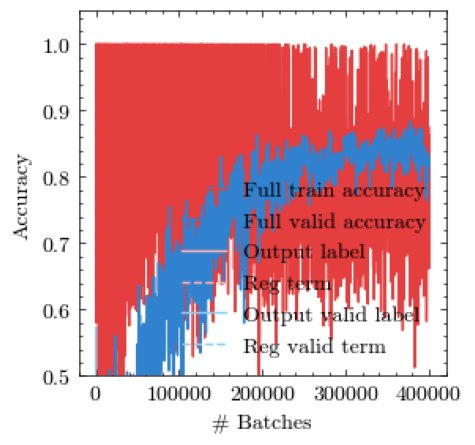

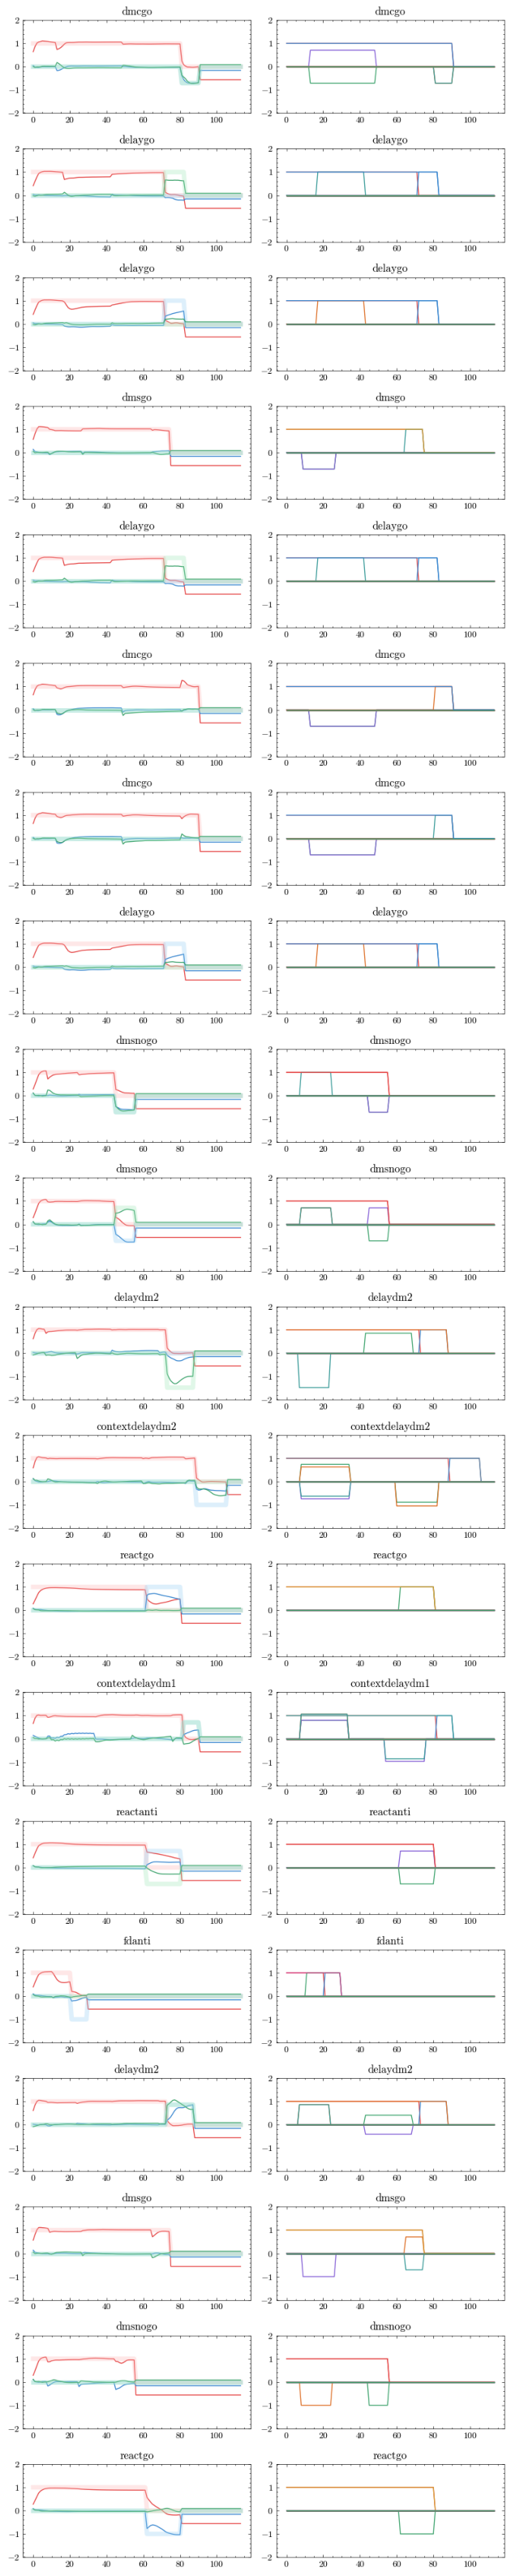

In [4]:
from pathlib import Path
from PIL import Image

def find_pngs_with_components(root, components, recursive=True, case_sensitive=False):
    """
    Return a list of Paths to .png files whose *filenames* contain all substrings in `components`.
    """
    root = Path(root)
    if not case_sensitive:
        components = [c.lower() for c in components]

    candidates = root.rglob("*.png") if recursive else root.glob("*.png")
    matches = []
    for p in candidates:
        name = p.name if case_sensitive else p.name.lower()
        if all(c in name for c in components):
            matches.append(p)

    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches

def show_image(path, size=(6,6)):
    img = Image.open(path)
    fig, ax = plt.subplots(1,1,figsize=size)
    ax.imshow(img)
    ax.axis('off')
    fig.show()

search_root = "./multiple_tasks/"

components_loss = ["loss", f"seed{seed}"]    
matches_loss = find_pngs_with_components(search_root, components_loss,
                                    recursive=True, case_sensitive=False)
show_image(matches_loss[0])

components_showcase = ["lowD", f"seed{seed}"]    
matches_showcase = find_pngs_with_components(search_root, components_showcase,
                                    recursive=True, case_sensitive=False)
show_image(matches_showcase[0], size=(4*2,4*20))

In [ ]:
clustering_data_analysis = [xs, hs, Ms_orig]
clustering_data_analysis_names = ["input", "hidden", "modulation_all"]

# clustering_data_analysis = [xs, hs]
# clustering_data_analysis_names = ["input", "hidden"]

clustering_data_hierarchy = {}
clustering_corr_info = []
col_clusters_all, row_clusters_all = [], []
row_cluster_breaker_all = []
input_hidden_comparison = []
default_rowname = None
base_data = []
metrics_all_all = []

selection_key = ["CH_blocks", "DB_blocks"]

upper_cluster = 300
lower_cluster = 5

for clustering_index in range(len(clustering_data_analysis)): 
    print("======================================================")
    clustering_data = clustering_data_analysis[clustering_index]
    clustering_name = clustering_data_analysis_names[clustering_index]
    print(f"clustering_name: {clustering_name}")
    
    if hyp_dict['ruleset'] == "everything": 
        phase_to_indices = [
            ("stim1",  [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
            ("stim2",  [6, 7, 8, 9, 10]),
            ("delay1", [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]),
            ("delay2", [6, 7, 8, 9, 10]),
            ("go1",    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
        ]
    elif hyp_dict['ruleset'] == "contextdelaydm1":
        phase_to_indices = [
            ("stim1", [0]), 
            ("stim2", [0]), 
            ("delay1", [0]), 
            ("delay2", [0]), 
            ("go1", [0]), 
        ]

    elif hyp_dict['ruleset'] == "delaydm1":
        phase_to_indices = [
            ("stim1", [0]), 
            ("stim2", [0]), 
            ("delay1", [0]), 
            ("delay2", [0]), 
            ("go1", [0]), 
        ]

    elif hyp_dict['ruleset'] == "dmcgo":
        phase_to_indices = [
            ("stim1", [0]), 
            ("delay1", [0]), 
            ("go1", [0]), 
        ]
    
    tb_break = [
        [idx, rules_epochs[all_rules[idx]][phase]]
        for phase, indices in phase_to_indices
        for idx in indices
    ]
    
    tb_break_name = [
        f"{all_rules[idx]}-{phase}"
        for phase, indices in phase_to_indices
        for idx in indices
    ]
    
    tb_break_name = np.array(tb_break_name)
    
    cell_vars_rules = [] 
    
    for el in range(len(tb_break)):
        n_rules = len(task_params['rules'])
        n_cells = clustering_data.shape[-1]
            
        rule_idx, period_time = tb_break[el][0], tb_break[el][1]
        
        # print('Rule {} (idx {})'.format(all_rules[rule_idx], rule_idx))
        if len(clustering_data.shape) == 3:
            rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1], :]
            cell_vars_rules.append(np.var(rule_cluster, axis=(0, 1))) 
        else:
            clustering_data_old = clustering_data
            if "pre" in clustering_name:
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1]]
                mean_var = np.var(rule_cluster, axis=(0, 1)).mean(axis=0)
                cell_vars_rules.append(mean_var)
                
            elif "post" in clustering_name: 
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1]]
                mean_var = np.var(rule_cluster, axis=(0, 1)).mean(axis=1)
                cell_vars_rules.append(mean_var)
                
            elif "all" in clustering_name: 
                clustering_data = clustering_data.reshape(clustering_data.shape[0], clustering_data.shape[1], -1)
                rule_cluster = clustering_data[test_task == rule_idx, period_time[0]:period_time[1], :]
                cell_vars_rules.append(np.var(rule_cluster, axis=(0, 1))) 
                    
    cell_vars_rules = np.array(cell_vars_rules)    
    cell_vars_rules_norm = np.zeros_like(cell_vars_rules)
    
    # normalize
    cell_max_var = np.max(cell_vars_rules, axis=0) # Across rules
    for period_idx in range(len(tb_break)):
        cell_vars_rules_norm[period_idx] = np.where(
            cell_max_var > 0., cell_vars_rules[period_idx] / cell_max_var, 0.
        )

    # modulation only, reshape to (N, pre, post) shape after calculating the variance
    # N here as the number of sessions after breakdown
    if "all" in clustering_name: 
        N, MM = cell_vars_rules_norm.shape
        M = int(np.sqrt(MM))
        cell_vars_rules_norm_keepshape = cell_vars_rules_norm.reshape(N, M, M)
    
    # build rule-wise value lists and corresponding field names dynamically
    rule_vals  = [cell_vars_rules_norm[i].tolist() for i in range(n_rules)]
    # print(f"rule_vals: {rule_vals}")
    rule_names = [f"rule{i}" for i in range(n_rules)]
    
    # structured array whose fields are rule0, rule1, …, rule{n_rules-1}
    dtype = np.dtype([(name, float) for name in rule_names])
    rules_struct = np.array(list(zip(*rule_vals)), dtype=dtype)
    
    # sort_idxs = np.argsort(rules_struct, order=rule_names)[::-1] # descending lexicographic sort across all rule columns 
    sort_idxs = np.arange(rules_struct.shape[0], dtype=np.intp) # identity map 

    # July 7th: first sorting based on the normalized magnitude
    # all the following should be aligned with this change
    # Aug 22th: sort based on the variance ordering OR using an identity map (i.e. do nothing)
    cell_vars_rules_sorted_norm = cell_vars_rules_norm[:, sort_idxs]
    base_data.append(cell_vars_rules_sorted_norm)
    print(f"cell_vars_rules_sorted_norm: {cell_vars_rules_sorted_norm.shape}")

    # not plotting the modulation result for its large dimensionality
    if "all" not in clustering_name: 
        fig, ax = plt.subplots(2,1,figsize=(24,8*2))
        for period_idx in range(cell_vars_rules_sorted_norm.shape[0]): 
            ax[0].plot(cell_vars_rules_sorted_norm[period_idx], color=c_vals[period_idx], label=tb_break_name[period_idx])
        ax[0].set_xlabel('Cell_idx')
        ax[0].set_ylabel('Normalized task variance')
        ax[0].set_title(clustering_name, fontsize=15)
        
        sns.heatmap(cell_vars_rules_sorted_norm, ax=ax[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        ax[1].set_xlabel('Cell idx')
        ax[1].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
        default_rowname = tb_break_name
        ax[1].set_yticks(np.arange(len(tb_break_name)))
        ax[1].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        ax[1].set_title(clustering_name, fontsize=15)
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)   

    # plot the operations for input and hidden
    if not ("all" in clustering_name): 
        # clustering & grouping & re-ordering
        # first loop on input, second loop in hidden
        result = clustering.cluster_variance_matrix_repeat(cell_vars_rules_sorted_norm, k_min=lower_cluster, k_max=upper_cluster, \
                                                    metric="euclidean", method="ward", n_repeats=100)
        
        eval_res = clustering_metric.evaluate_bicluster_clustering(
            cell_vars_rules_sorted_norm, row_labels=result["row_labels"], col_labels=result["col_labels"]
        )
        eval_metrics = eval_res["metrics"]
        eval_blocks = eval_res["blocks"]
        eval_stdmean = np.median(eval_blocks["std"] / eval_blocks["means"])

        eval_random_metrics_all = []
        eval_random_blocks_all = []
        for repeat in range(1000):
            rng = np.random.default_rng(seed=np.random.randint(0, 10000))
            # row_arr = rng.integers(1, np.max(result["row_labels"]+1), size=len(result["row_labels"]), endpoint=False)
            # col_arr = rng.integers(1, np.max(result["col_labels"]+1), size=len(result["col_labels"]), endpoint=False)
            row_arr = rng.permutation(result["row_labels"])
            col_arr = rng.permutation(result["col_labels"])
            eval_res_random = clustering_metric.evaluate_bicluster_clustering(
                cell_vars_rules_sorted_norm, row_labels=row_arr, col_labels=col_arr
            )
            eval_random_metrics_all.append(eval_res_random["metrics"])
            eval_random_blocks_all.append(eval_res_random["blocks"])

        eval_random_stdmean = [np.nanmedian(eval_random_blocks["std"] / eval_random_blocks["means"]) \
                                       for eval_random_blocks in eval_random_blocks_all]

        metrics_all = {}
        for metric_key in selection_key: 
            optimized_value = eval_metrics[metric_key]
            random_values = [eval_random_metrics[metric_key] for eval_random_metrics in eval_random_metrics_all]
            metrics_all[metric_key] = [optimized_value, np.mean(random_values), np.std(random_values, ddof=1)/np.sqrt(len(random_values))]

        metrics_all["std/mean"] = [eval_stdmean, np.mean(eval_random_stdmean), np.std(eval_random_stdmean, ddof=1)/np.sqrt(len(eval_random_stdmean))]
        print(f"metrics_all: {metrics_all}")
        
        # registeration
        metrics_all_all.append(metrics_all) 

        input_hidden_comparison.append([result, cell_vars_rules_sorted_norm])
        
        cell_vars_rules_sorted_norm_ordered = cell_vars_rules_sorted_norm[np.ix_(result["row_order"], result["col_order"])]
        
        rl = np.asarray(result["row_labels"])[result["row_order"]]
        cl = np.asarray(result["col_labels"])[result["col_order"]]
        rbreaks = clustering._breaks(rl)
        cbreaks = clustering._breaks(cl)

        best_k_row, best_k_col = result["row_k"], result["col_k"]
        row_t, col_t = result["row_cut_threshold"], result["col_cut_threshold"] 

        # extract the grouping information, i.e. which neuron belong to which cluster
        # instead of the view of dendrogram
        col_labels, col_k = result["col_labels"], result["col_k"]
        col_clusters = {int(lab): np.where(col_labels == lab)[0] for lab in np.unique(col_labels)}
        col_clusters_all.append(col_clusters)
        row_labels, row_k = result["row_labels"], result["row_k"]
        row_clusters = {int(lab): np.where(row_labels == lab)[0] for lab in np.unique(row_labels)}
        row_clusters_all.append(row_clusters)
        
        # plot the optimization score as a function of number of clustering
        figscore, axscore = plt.subplots(1,1,figsize=(10,3))
        axscore.plot(result["row_score_recording_mean"].keys(), result["row_score_recording_mean"].values(), \
                     label="row", color=c_vals[0])
        axscore.plot(result["col_score_recording_mean"].keys(), result["col_score_recording_mean"].values(), \
                     label="col", color=c_vals[1])
        axscore.set_xlabel("Number of Cluster")
        axscore.set_ylabel("Silhouette Score")
        axscore.legend()
        axscore.set_title(f"{clustering_name}", fontsize=15)
        figscore.tight_layout()
        figscore.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_score_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # 
        ordered_row_name = tb_break_name[result["row_order"]]
        row_breakers = [0]
        for row_group in row_clusters.values():
            row_breakers.append(row_breakers[-1] + len(row_group))
        row_breakers = row_breakers[1:]
        print(f"row_breakers: {row_breakers}")
        row_cluster_breaker_all.append(row_breakers)
        
        # pearson correlation matrix
        figcorr, axcorrs = plt.subplots(1,3,figsize=(8*3,8))
        metrics = ["Correlation", "Cosine Similarity", "L2 Distance"]
        cell_vars_rules_sorted_norm_ordered_measure = np.corrcoef(cell_vars_rules_sorted_norm_ordered, rowvar=True)
        cell_vars_rules_sorted_norm_ordered_measure_cos = cosine_similarity(cell_vars_rules_sorted_norm_ordered)
        cell_vars_rules_sorted_norm_ordered_measure_L2  = squareform(pdist(cell_vars_rules_sorted_norm_ordered, metric='euclidean'))

        # set uniform colorbar to cross-compare between analysis
        sns.heatmap(cell_vars_rules_sorted_norm_ordered_measure, cmap="coolwarm", square=True, vmin=-0.5, vmax=1.0, ax=axcorrs[0])
        sns.heatmap(cell_vars_rules_sorted_norm_ordered_measure_cos, cmap="coolwarm", square=True, vmin=-0.5, vmax=1.0, ax=axcorrs[1])
        sns.heatmap(cell_vars_rules_sorted_norm_ordered_measure_L2, cmap="coolwarm", square=True, ax=axcorrs[2])

        for axcorr_index in range(len(axcorrs)): 
            axcorr = axcorrs[axcorr_index]
            # plot the group information (delimiter between different cluster)
            nn = cell_vars_rules_sorted_norm_ordered_measure.shape[0]
            boundaries = row_breakers
            for b in boundaries:
                axcorr.axvline(b, 0, 1, color="k", linewidth=1.2)
                axcorr.axhline(b, 0, 1, color="k", linewidth=1.2)
            
            axcorr.set_xticks(np.arange(len(tb_break_name)))
            axcorr.set_xticklabels(tb_break_name[result["row_order"]], rotation=90, ha='right', va='center', \
                                   rotation_mode='anchor', fontsize=9)    
            axcorr.set_yticks(np.arange(len(tb_break_name)))
            axcorr.set_yticklabels(tb_break_name[result["row_order"]], rotation=0, ha='right', va='center', \
                                   rotation_mode='anchor', fontsize=9) 
            axcorr.tick_params(axis="both", length=0)
            axcorr.set_title(f"{clustering_name}-{metrics[axcorr_index]}", fontsize=15)
        
        figcorr.tight_layout()
        figcorr.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_corr_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # register correlation information
        clustering_corr_info.append([
            cell_vars_rules_sorted_norm_ordered_measure, ordered_row_name, result["col_order"]
        ])

        # plot the effect of grouping & ordering through the feature axis
        fig, ax = plt.subplots(2,1,figsize=(24,8*2))
        sns.heatmap(cell_vars_rules_sorted_norm, ax=ax[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_ordered, ax=ax[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        for rb in rbreaks:
            ax[1].axhline(rb, color="k", lw=0.6)
        for cb in cbreaks:
            ax[1].axvline(cb, color="k", lw=0.6)
        ax[0].set_title(f"Before Clustering; best k row: {best_k_row}; best k col: {best_k_col}", fontsize=15)
        ax[0].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
        ax[0].set_yticks(np.arange(len(tb_break_name)))
        ax[0].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        ax[1].set_title(f"After Clustering; best k row: {best_k_row}; best k col: {best_k_col}", fontsize=15)
        ax[1].set_ylabel('Rule / Break-name', fontsize=12, labelpad=12)
        ax[1].set_yticks(np.arange(len(tb_break_name)))
        ax[1].set_yticklabels(tb_break_name[result["row_order"]], rotation=0, ha='right', va='center', fontsize=9)    
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # plot the norm of normalized variance of each session (across the neuron dimension)
        session_norm = cell_vars_rules_sorted_norm_ordered.sum(axis=1)
        norm_order = np.argsort(-session_norm)
        session_norm = session_norm[norm_order]
        session_norm_name = (tb_break_name[result["row_order"]])[norm_order]
        fig, ax = plt.subplots(1,1,figsize=(15,3))
        ax.plot([i for i in range(len(session_norm))], session_norm, "-o")
        ax.set_xticks([i for i in range(len(session_norm))])
        ax.set_xticklabels(session_norm_name, rotation=90, ha="right")
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_norm_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
        
        # plot hierarchy of grouping 
        fig, axs = plt.subplots(2,1,figsize=(25,4*2))
        dendrogram(result["row_linkage"], ax=axs[0], labels=tb_break_name[result["row_order"]], leaf_rotation=90)
        axs[0].axhline(row_t, linestyle="--", color="black")
        axs[0].set_title(f"Row hierarchy (k = {result['row_k']})", fontsize=15)
        dendrogram(result["col_linkage"], ax=axs[1], labels=np.array([i for i in range(cell_vars_rules_sorted_norm_ordered.shape[1])]), leaf_rotation=90)
        axs[1].set_title(f"Col hierarchy (k = {result['col_k']})", fontsize=15)
        axs[1].axhline(col_t, linestyle="--", color="black")
        fig.suptitle(clustering_name, fontsize=15)
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{clustering_name}_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # register hierarchy clustering
        clustering_data_hierarchy[clustering_name] = result["col_linkage"]

    # align the correlation matrix for input and hidden based on an identical ordering 
    # this loop will be run during the hidden analysis iteration (not modulation iteration)
    if (len(clustering_corr_info) == 2) and ("all" not in clustering_name):
        input_order_row, hidden_order_row = clustering_corr_info[0][1], clustering_corr_info[1][1]
        input_corr, hidden_corr = clustering_corr_info[0][0], clustering_corr_info[1][0]
        shuffle_hidden_to_input = helper.permutation_indices_b_to_a(input_order_row, hidden_order_row)
        # reordering
        hidden_corr_input = hidden_corr[np.ix_(shuffle_hidden_to_input, shuffle_hidden_to_input)]

        # 
        figinputhiddencorr, axinputhiddencorr = plt.subplots(1,2,figsize=(8*2,8))
        sns.heatmap(input_corr, ax=axinputhiddencorr[0], cmap="coolwarm", square=True, vmin=-0.5, vmax=1.0)
        sns.heatmap(hidden_corr_input, ax=axinputhiddencorr[1], cmap="coolwarm", square=True, vmin=-0.5, vmax=1.0)

        for ax in axinputhiddencorr:
            ax.set_xticks(np.arange(len(input_order_row)))
            ax.set_xticklabels(input_order_row, rotation=90, ha='right', va='center', \
                                   rotation_mode='anchor', fontsize=9)    
            ax.set_yticks(np.arange(len(input_order_row)))
            ax.set_yticklabels(input_order_row, rotation=0, ha='right', va='center', \
                                   rotation_mode='anchor', fontsize=9) 
            ax.tick_params(axis="both", length=0)

        axinputhiddencorr[0].set_title("Input Correlation", fontsize=15)
        axinputhiddencorr[1].set_title("Hidden Correlation (Reordered By Input Correlation)", fontsize=15)
        for ax in axinputhiddencorr:
            for b in row_cluster_breaker_all[0]:
                ax.axvline(b, 0, 1, color="k", linewidth=1.2)
                ax.axhline(b, 0, 1, color="k", linewidth=1.2)
            
        figinputhiddencorr.suptitle("Reorder Input & Hidden Correlation")
        figinputhiddencorr.savefig(f"./multiple_tasks/input2hidden_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # # comparing the transfer of clustering information
        # scores_B_to_A1 = clustering.transfer_and_score(input_hidden_comparison[0][1], input_hidden_comparison[1][1], \
        #                                            input_hidden_comparison[0][0], input_hidden_comparison[1][0], metric="euclidean")
        # # use hidden clustering information to cluster input
        # figcompare, axcompare = clustering.show_A_ordered_by_B(A=input_hidden_comparison[0][1], \
        #                                             res_B=input_hidden_comparison[1][0], \
        #                                             row_name=default_rowname
        # )
        # axcompare.set_title(f"Input using Hidden: row: {scores_B_to_A1['row_silhouette_on_A']:2f}; col: {scores_B_to_A1['col_silhouette_on_A']:2f}", fontsize=15)
        # figcompare.savefig(f"./multiple_tasks/inputusehidden_crossclustering_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # scores_B_to_A2 = clustering.transfer_and_score(input_hidden_comparison[1][1], input_hidden_comparison[0][1], \
        #                                            input_hidden_comparison[1][0], input_hidden_comparison[0][0], metric="euclidean")
        
        # figcompare2, axcompare2 = clustering.show_A_ordered_by_B(A=input_hidden_comparison[1][1], \
        #                                             res_B=input_hidden_comparison[0][0], \
        #                                             row_name=default_rowname
        # )
        # axcompare2.set_title(f"Hidden using Input: row: {scores_B_to_A2['row_silhouette_on_A']:2f}; col: {scores_B_to_A2['col_silhouette_on_A']:2f}", fontsize=15)
        # figcompare2.savefig(f"./multiple_tasks/hiddenuseinput_crossclustering_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

    # use the clustering result for input and hidden to order the modulation information
    # and/or cross-compare the clustering result from input & hidden 
    # trying to observe consistency in between
    if (len(clustering_corr_info) == 2) and ("all" in clustering_name):
        #  
        input_order_col_ind, hidden_order_col_ind = clustering_corr_info[0][2], clustering_corr_info[1][2]
        # cell_vars_rules_norm_keepshape: 3D array
        # sort the modulation matrix based on the pre (input) and post (hidden) neuron ordering
        cell_vars_rules_norm_keepshape_ih = cell_vars_rules_norm_keepshape[:, input_order_col_ind, :]
        cell_vars_rules_norm_keepshape_ih = cell_vars_rules_norm_keepshape_ih[:, :, hidden_order_col_ind]

        flatten_by_pre = cell_vars_rules_norm_keepshape_ih.reshape(N, M*M)
        flatten_by_post = cell_vars_rules_norm_keepshape_ih.transpose(0,2,1).reshape(N, M*M)

        fig, axs = plt.subplots(2,1,figsize=(24,8*2))
        sns.heatmap(flatten_by_pre, ax=axs[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(flatten_by_post, ax=axs[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        axs[0].set_title("Flatten By Pre (Input)", fontsize=15)
        axs[1].set_title("Flatten By Post (Hidden)", fontsize=15)
        for ax in axs: 
            ax.set_yticks(np.arange(len(tb_break_name)))
            ax.set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/modulation_input2hidden_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # 
        print(cell_vars_rules_sorted_norm.shape)
        cluster_input, cluster_hidden = col_clusters_all[0], col_clusters_all[1]
        cluster_combine = {}
        newc = 0
        for c1 in cluster_input.keys(): # input cluster name
            for c2 in cluster_hidden.keys(): # hidden cluster name
                newc += 1 # iterative counter of new cell type
                # different newc stands for a unique cell type 
                # (defined as a multiplication cluster of pre [input] and post [hidden])
                nc1_input, nc2_hidden = cluster_input[c1], cluster_hidden[c2]
                nc_combine = [(int(i),int(j)) for i in nc1_input for j in nc2_hidden]
                # transform to reshaped matrix index
                nc_combine = [cc[0] * M + cc[1] for cc in nc_combine]
                cluster_combine[newc] = nc_combine

        cluster_input_num, cluster_hidden_num = len(cluster_input), len(cluster_hidden)
        print(f"cluster_input_num: {cluster_input_num}; cluster_hidden_num: {cluster_hidden_num}")
        # by the setup, cluster_combine will be organized by shared pre
        # same pre neuron will be placed adjacently
        cluster_combine_pre = copy.deepcopy(cluster_combine)
        # create order of key to put post neuron together 
        post_order = []
        for c1 in range(cluster_input_num):
            for c2 in range(cluster_hidden_num):
                post_order.append(c1 + c2 * cluster_input_num + 1) 

        pre_order = list(cluster_combine.keys())
        # print(f"pre_order: {pre_order}")
        # print(f"post_order: {post_order}")

        pre_order_group, post_order_group = [], [] 
        for ind in range(cluster_hidden_num):
            pre_order_group.append([i+1 for i in range(ind * cluster_input_num, (ind+1) * cluster_input_num)])
        for ind in range(cluster_input_num):
            block = []
            for ind2 in range(cluster_hidden_num):
                block.append(ind + ind2 * cluster_input_num + 1)
            post_order_group.append(block)
        
        group_neurons_comb_pre, group_neurons_comb_post = [], [] 
        for preo in pre_order:
            group_neurons_comb_pre.extend(cluster_combine[preo])
        for posto in post_order:
            group_neurons_comb_post.extend(cluster_combine[posto])

        # Sep 2nd: we dont want random order of cell type
        # but based on certain pre or post neuron clustering 
        # random_celltype_orders = helper.concat_random_samples(cluster_combine, n_samples=1, seed=42)
        # random_celltype_orders = random_celltype_orders[0] # take the first sample
        # group_neurons_comb = random_celltype_orders[0] # concatenated list
        # assert len(group_neurons_comb) == len(set(group_neurons_comb)) # every element is unique
        # group_neurons = random_celltype_orders[1] # list of list, the order does not matter here

        group_neurons = [group for group in cluster_combine.values()]

        group_neurons_pre = []
        for pre_order_ in pre_order_group:
            block = []
            for ind in pre_order_:
                block.extend(group_neurons[ind-1])
            group_neurons_pre.append(block)

        group_neurons_post = []
        for post_order_ in post_order_group:
            block = []
            for ind in post_order_:
                block.extend(group_neurons[ind-1])
            group_neurons_post.append(block)

        # assert helper.all_leq(group_neurons_comb, cell_vars_rules_sorted_norm.shape[1])

        # cell_vars_rules_sorted_norm_r1 = cell_vars_rules_sorted_norm[:,group_neurons_comb]
        cell_vars_rules_sorted_norm_outer_bypre = cell_vars_rules_sorted_norm[:,group_neurons_comb_pre]
        cell_vars_rules_sorted_norm_outer_bypost = cell_vars_rules_sorted_norm[:,group_neurons_comb_post]
                
        fig, axs = plt.subplots(6,1,figsize=(24,8*6))
        sns.heatmap(cell_vars_rules_sorted_norm, ax=axs[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_outer_bypre, ax=axs[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_outer_bypost, ax=axs[2], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        axs[0].set_title("Original", fontsize=15)
        axs[1].set_title(f"Ordering based on the Outer Product of Input & Hidden Clusters [Input Adjacent]", fontsize=15)
        axs[2].set_title(f"Ordering based on the Outer Product of Input & Hidden Clusters [Hidden Adjacent]", fontsize=15)
        for iii in range(3):
            axs[iii].set_yticks(np.arange(len(tb_break_name)))
            axs[iii].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)

        group_all = [group_neurons, group_neurons_pre, group_neurons_post]
        group_all_names = ["Outer Product of Input & Hidden Clusters", "Shared Hidden", "Shared Input"]

        for group_neurons_index in range(len(group_all)):
            group_neurons_ = group_all[group_neurons_index]
            result_outer = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, \
                                                                     col_groups=group_neurons_, k_min=int(lower_cluster-1), k_max=upper_cluster)
            prior_cluster_num = len(group_neurons_)
            cell_vars_rules_sorted_norm_inputhidden = cell_vars_rules_sorted_norm[np.ix_(result_outer["row_order"], result_outer["col_order"])]
    
            sns.heatmap(cell_vars_rules_sorted_norm_inputhidden, ax=axs[3+group_neurons_index], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
            axs[3+group_neurons_index].set_yticks(np.arange(len(tb_break_name)))
            axs[3+group_neurons_index].set_yticklabels(tb_break_name[result_outer["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
            axs[3+group_neurons_index].set_title(f"Ordering based on the {group_all_names[group_neurons_index]}, #{prior_cluster_num} [Post-Clustering]", fontsize=15)
            
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/modulation_input2hiddentogether_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
            
    # plot the conditional grouping for modulation
    # currently grouped based on modulation-pre and modulation-post separately
    if ("all" in clustering_name): 
        assert len(clustering_data_old.shape) == 4
        pre_num, post_num = clustering_data_old.shape[2], clustering_data_old.shape[3]
        feature_group_post = [] 
        for i in range(post_num):
            feature_group_post.append(helper.basic_sort([i + j * post_num for j in range(pre_num)], sort_idxs))
        feature_group_pre = []
        for i in range(pre_num):
            feature_group_pre.append(helper.basic_sort([j for j in range(post_num * i, post_num * (i+1))], sort_idxs))

        result_pre = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, \
                                                                 col_groups=feature_group_pre, k_min=lower_cluster, k_max=upper_cluster)
        result_post = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, \
                                                                  col_groups=feature_group_post, k_min=lower_cluster, k_max=upper_cluster)

        # Oct 6th: do not give any prior grouping prior to the modulation information
        # simply grouping and considering each individual column as separate
        G = 3000
        col_groups_all, col_labels_all, centroids_all = clustering.make_col_groups_with_kmeans(cell_vars_rules_sorted_norm, \
                                                                                               n_groups=G)

        result_all = clustering.cluster_variance_matrix_forgroup(cell_vars_rules_sorted_norm, row_groups=None, \
                                                                    col_groups=col_groups_all, k_min=lower_cluster, k_max=G)

        cell_vars_rules_sorted_norm_pre = cell_vars_rules_sorted_norm[np.ix_(result_pre["row_order"], result_pre["col_order"])]
        cell_vars_rules_sorted_norm_post = cell_vars_rules_sorted_norm[np.ix_(result_post["row_order"], result_post["col_order"])]
        cell_vars_rules_sorted_norm_all = cell_vars_rules_sorted_norm[np.ix_(result_all["row_order"], result_all["col_order"])]

        clustering_data_hierarchy["modulation_all_pre"] = result_pre["col_linkage"]
        clustering_data_hierarchy["modulation_all_post"] = result_post["col_linkage"]

        figprepost, axprepost = plt.subplots(4,1,figsize=(24,8*4))
        sns.heatmap(cell_vars_rules_sorted_norm, ax=axprepost[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_pre, ax=axprepost[1], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_post, ax=axprepost[2], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        sns.heatmap(cell_vars_rules_sorted_norm_all, ax=axprepost[3], cmap="coolwarm", cbar=True, vmin=0, vmax=1)

        for ax in axprepost:
            ax.set_yticks(np.arange(len(tb_break_name)))
        axprepost[0].set_yticklabels(tb_break_name, rotation=0, ha='right', va='center', fontsize=9)
        axprepost[1].set_yticklabels(tb_break_name[result_pre["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
        axprepost[2].set_yticklabels(tb_break_name[result_post["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
        axprepost[3].set_yticklabels(tb_break_name[result_all["row_order"]], rotation=0, ha='right', va='center', fontsize=9)
        axprepost[0].set_title("Original", fontsize=15)
        axprepost[1].set_title(f"Group by Pre, #{upper_cluster}", fontsize=15)
        axprepost[2].set_title(f"Group by Post, #{upper_cluster}", fontsize=15)
        axprepost[3].set_title(f"Group by All, #{upper_cluster}", fontsize=15)
        figprepost.tight_layout()
        figprepost.savefig(f"./multiple_tasks/{clustering_name}_bygroup_variance_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)  

        fig, axs = plt.subplots(4,1,figsize=(25*1,4*4))
        dendrogram(result_pre["row_linkage"], ax=axs[0], labels=tb_break_name[result_pre["row_order"]], leaf_rotation=90)
        axs[0].set_title(f"Row hierarchy (k = {result_pre['row_k']})", fontsize=15)
        dendrogram(result_pre["col_linkage"], ax=axs[1], labels=np.array([i for i in range(result_pre["col_linkage"].shape[0]+1)]), leaf_rotation=90)
        axs[1].set_title(f"Col hierarchy (k = {result_pre['col_k']})", fontsize=15)
        dendrogram(result_post["row_linkage"], ax=axs[2], labels=tb_break_name[result_post["row_order"]], leaf_rotation=90)
        axs[2].set_title(f"Row hierarchy (k = {result_post['row_k']})", fontsize=15)
        dendrogram(result_post["col_linkage"], ax=axs[3], labels=np.array([i for i in range(result_post["col_linkage"].shape[0]+1)]), leaf_rotation=90)
        axs[3].set_title(f"Col hierarchy (k = {result_post['col_k']})", fontsize=15)
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{clustering_name}_bygroup_variance_hierarchy_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300) 

        figscore, axscore = plt.subplots(1,1,figsize=(10,3))
        axscore.plot(result_pre["row_score_recording"].keys(), result_pre["row_score_recording"].values(), \
                     label="row pre", color=c_vals[0])
        axscore.plot(result_pre["col_score_recording"].keys(), result_pre["col_score_recording"].values(), \
                     label="col pre", color=c_vals[1])
        axscore.plot(result_post["row_score_recording"].keys(), result_post["row_score_recording"].values(), \
                     label="row post", color=c_vals[2])
        axscore.plot(result_post["col_score_recording"].keys(), result_post["col_score_recording"].values(), \
                     label="col post", color=c_vals[3])
        axscore.plot(result_all["row_score_recording"].keys(), result_all["row_score_recording"].values(), \
                     label="row all", color=c_vals[4], linestyle="--")
        axscore.plot(result_all["col_score_recording"].keys(), result_all["col_score_recording"].values(), \
                     label="col all", color=c_vals[5], linestyle="--")
        axscore.set_xlabel("Number of Cluster")
        axscore.set_ylabel("Silhouette Score")
        axscore.legend()
        axscore.set_title(clustering_name, fontsize=15)
        axscore.set_xscale("log")
        figscore.tight_layout()
        figscore.savefig(f"./multiple_tasks/{clustering_name}_variance_cluster_score_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        input_info, hidden_info = base_data[0], base_data[1]
        
        # figmodih, axsmodih = plt.subplots(4,1,figsize=(25*1,8*4))
        # sns.heatmap(input_info, ax=axsmodih[0], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        # sns.heatmap(input_info[np.ix_(result_pre["row_group_order"], result_pre["col_group_order"])], ax=axsmodih[1], \
        #             cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        # sns.heatmap(hidden_info, ax=axsmodih[2], cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        # sns.heatmap(hidden_info[np.ix_(result_post["row_group_order"], result_post["col_group_order"])], ax=axsmodih[3], \
        #             cmap="coolwarm", cbar=True, vmin=0, vmax=1)
        # for ax in axsmodih.flatten():
        #     ax.set_yticks(np.arange(len(default_rowname)))
        # axsmodih[0].set_yticklabels(default_rowname, rotation=0, ha='right', va='center', fontsize=9)
        # axsmodih[0].set_title("Input")
        # axsmodih[1].set_yticklabels(default_rowname[result_pre["row_group_order"]], rotation=0, ha='right', va='center', fontsize=9)
        # axsmodih[1].set_title("Input using Modulation by Pre")
        # axsmodih[2].set_yticklabels(default_rowname, rotation=0, ha='right', va='center', fontsize=9)
        # axsmodih[2].set_title("Hidden")
        # axsmodih[3].set_yticklabels(default_rowname[result_post["row_group_order"]], rotation=0, ha='right', va='center', fontsize=9)
        # axsmodih[3].set_title("Input using Modulation by Post")
        # figmodih.tight_layout()
        # figmodih.savefig(f"./multiple_tasks/{clustering_name}_use_modulation_on_inputhidden_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
        # print(result_pre["row_group_labels"])

        # using the grouping result for the modulation (pre/post) to (input/hidden)
        # and use quantitative metric to compare the 
        eval_res_modulation_on_input = clustering_metric.evaluate_bicluster_clustering(
            input_info, row_labels=result_pre["row_group_labels"], col_labels=result_pre["col_group_labels"]
        )

        eval_res_modulation_on_hidden = clustering_metric.evaluate_bicluster_clustering(
            hidden_info, row_labels=result_post["row_group_labels"], col_labels=result_post["col_group_labels"]
        )

        # concatenate metric-specific result to the input/hidden saver
        for key in selection_key:
            metrics_all_all[0][key].append(eval_res_modulation_on_input["metrics"][key]) # input
            metrics_all_all[1][key].append(eval_res_modulation_on_hidden["metrics"][key]) # hidden

        metrics_all_all[0]["std/mean"].append(np.median(eval_res_modulation_on_input["blocks"]["std"] / eval_res_modulation_on_input["blocks"]["means"]))
        metrics_all_all[1]["std/mean"].append(np.median(eval_res_modulation_on_hidden["blocks"]["std"] / eval_res_modulation_on_hidden["blocks"]["means"]))

        repeat_names = ["input", "hidden"]
        for repeat_index in range(len(repeat_names)):
            repeat_name = repeat_names[repeat_index]
            # print(f"repeat_name: {repeat_name}")
            metrics_all = metrics_all_all[repeat_index]
            
            figquan, axsquan = plt.subplots(1,len(metrics_all), figsize=(4*len(metrics_all),4))
            metrics_all_keys = list(metrics_all.keys())
            # print(f"metrics_all_keys: {metrics_all_keys}")
            for metric_index in range(len(metrics_all_keys)):
                metric_key = metrics_all_keys[metric_index]
                metric_data = metrics_all[metric_key]
                # print(metric_data)
                axsquan[metric_index].scatter(0, metric_data[0], color=c_vals[metric_index]) # optimized
                axsquan[metric_index].scatter(1, metric_data[1], color=c_vals[metric_index]) # random
                axsquan[metric_index].errorbar(1, metric_data[1], yerr=metric_data[2], fmt='o', color=c_vals[metric_index], \
                                               capsize=5, elinewidth=1, markeredgewidth=1 
                )
                axsquan[metric_index].scatter(2, metric_data[3], color=c_vals[metric_index]) # modulation on input/hidden
                axsquan[metric_index].set_title(metric_key)
                axsquan[metric_index].set_xticks([i for i in range(3)])
                cluster_names = ["Optimized Clutering", "Random Clustering", "Modulation-Adapted Clustering"]
                axsquan[metric_index].set_xticklabels(cluster_names, rotation=45, ha='right', va='center', \
                                       rotation_mode='anchor', fontsize=9)
            figquan.tight_layout()
            figquan.savefig(f"./multiple_tasks/{repeat_name}_quantitative_criteria_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)

        # compare modulation grouping result
        # either using pre, post, or different level of K-means pre-clusters
        all_mod = [result_pre, result_post, result_all]
        all_mod_metric = []
        for mod_ in all_mod: 
            eval_res_modulation = clustering_metric.evaluate_bicluster_clustering(
                cell_vars_rules_sorted_norm, row_labels=mod_["row_labels"], col_labels=mod_["col_labels"]
            )
            all_mod_metric.append([
                eval_res_modulation["metrics"]["CH_blocks"],
                eval_res_modulation["metrics"]["DB_blocks"],
                np.median(eval_res_modulation["blocks"]["std"] / eval_res_modulation["blocks"]["means"])
            ])

        all_mod_metric = np.array(all_mod_metric)
        fig, ax = plt.subplots(1,len(all_mod_metric), figsize=(4*all_mod_metric.shape[1], 4))
        for i in range(all_mod_metric.shape[1]):
            ax[i].plot([j for j in range(all_mod_metric.shape[1])], all_mod_metric[:,i], "-o")
        fig.tight_layout()
        fig.savefig(f"./multiple_tasks/{repeat_name}_between_modulation_{hyp_dict['ruleset']}_seed{seed}_{hyp_dict['addon_name']}.png", dpi=300)
        
        

clustering_name: input
cell_vars_rules_sorted_norm: (49, 300)
metrics_all: {'CH_blocks': [1381.0563587649565, np.float64(17.827802599139964), np.float64(0.32482839489888937)], 'DB_blocks': [118.07089314813486, np.float64(2380.0015792816935), np.float64(256.6060639652482)], 'std/mean': [np.float64(0.83847920869594), np.float64(1.3471428277670805), np.float64(0.0030969834971790785)]}
row_breakers: [20, 31, 38, 40, 43, 49]
clustering_name: hidden
cell_vars_rules_sorted_norm: (49, 300)
metrics_all: {'CH_blocks': [145.45741693757546, np.float64(3.957802859510426), np.float64(0.04104221536256164)], 'DB_blocks': [1049.4034363884484, np.float64(9323.670764600105), np.float64(771.8484042329997)], 'std/mean': [np.float64(0.5319184037551561), np.float64(1.2036950544900096), np.float64(0.0018545111148018539)]}
row_breakers: [16, 25, 32, 34, 35, 37, 38, 40, 42, 43, 49]
clustering_name: modulation_all
cell_vars_rules_sorted_norm: (49, 90000)
